Necessary imports

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import np_utils
import os
import json
from tensorflow.keras.models import Sequential, model_from_json
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# XOR

Definition of Layer class from scratch

In [21]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

class Layer:
    def forward(self, inputs):
        pass
    
    def backward(self, inputs):
        pass
    
class Linear(Layer):
    def __init__(self, n_inputs, n_neurons):
        self.w = np.random.randn( n_neurons, n_inputs)
        self.b = np.ones((1 , n_neurons))
         
    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs @ self.w.T + self.b      
        return self.output
    
    def backward(self, output_grad, lr = 0.1):
        w_grad = np.dot( self.inputs.T, output_grad)   #3  4
        #input_grad = np.dot(self.weights.T, output_grad)
        self.w -= lr*(w_grad.T)
        self.b -= lr*(output_grad.T@np.ones(output_grad.shape[0]))
        if output_grad.ndim == 1:
            output_grad = np.expand_dims(output_grad,axis = 0).T
        return np.dot( output_grad, self.w)
    
class Sigmoid(Layer):
    def forward(self, inputs):
        self.output = 1 / ( 1+ np.exp(-inputs))
        return self.output
    
    def backward(self, d_loss):
        return d_loss * ( 1- d_loss)
        
        #return self.dw
        


class Softmax(Layer):
    def __init():
        pass
    def forward(self, inputs):
        exp_val = np.exp(inputs - np.max(inputs, axis = 1, keepdims= True))
        prob =  exp_val/ np.sum(exp_val, axis = 1, keepdims = True)
        self.output = prob
        return self.output
        
    def backward(self, dw):
        self.dw = dw
        self.dw *= self.y * (1-self.y)
        return self.dw


class HyperbolicTangent(Layer):
    
    def forward(self, inputs):
        self.output = ((np.exp(inputs) - np.exp(-inputs)) / np.exp(inputs) + np.exp(-inputs))
        return self.output
    
    def backward(self, dw):
        self.dw *= (1-self.output**2)
        return self.dw

# class MultiCrossEntropy(Layer):                                 #multilcass
#     def forward(self,inputs,  output):
#         loss = -output * np.log(inputs)
#         return np.sum(np.mean(loss, axis = 0))
        
#     def backward(self,y, output):
#         return y - output
    
class BinCrossEntropy(Layer):                                              #binary
    def forward(self,inputs,  output):
        self.output = output
        loss = output * np.log(inputs) + (1-output) *np.log(inputs)
        return np.sum(np.mean(loss, axis = 0))
        
    def backward(self,y):
        print(self.output, y)
        return self.output - y
    

creating a model class to call above class methods

In [22]:
import os
import json

class Sequential(Layer):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.Losses =[]
        self.layers = [Linear(self.X.shape[1], 3), Sigmoid(), Linear(3, 1), Sigmoid()]
#         self.model = Layer(self.layers, CrossEntropy())
        
    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i].forward(x)
        return x
    def backward(self, y):
        for j in reversed(range(len(self.layers))):
#             z = 0
#             z = c.forward(self.layers[j].forward(x.T, get_one_hot(y.astype(int), 3)))
#             print("Loss", z)
#             Losses.append(z)
#             d_loss = c.backward(x.T, get_one_hot(y.astype(int), 10))
            y = self.layers[j].backward(y)  
        return y
            
    def fit(self, samples, target):
        batch_size = 32
        correct = 0
        lr = 0.001

        for batch_idx in range(0, samples.shape[1], batch_size):
            start_idx = batch_idx
            end_idx = start_idx + batch_size if start_idx + batch_size < samples.shape[0] else samples.shape[0]
            batch_samples = samples[start_idx : end_idx]
            batch_targets = targets[start_idx : end_idx]

            y_hat = self.forward(batch_samples)
            
            c = BinCrossEntropy()
            loss = c.forward(y_hat.T, batch_targets)
            self.Losses.append(loss)
            print("loss in sequential", loss)
            d_loss = c.backward(batch_targets)

            y = self.backward(d_loss)  
            print("predicted y and true y", y_hat, batch_targets)

#             correct += np.sum(np.argmax(layer1_z, axis=0) == targets[start_idx : end_idx].astype(int)   
    def predict(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i].forward(x)
        return x

Assigning inputs to samples and outputs to targets

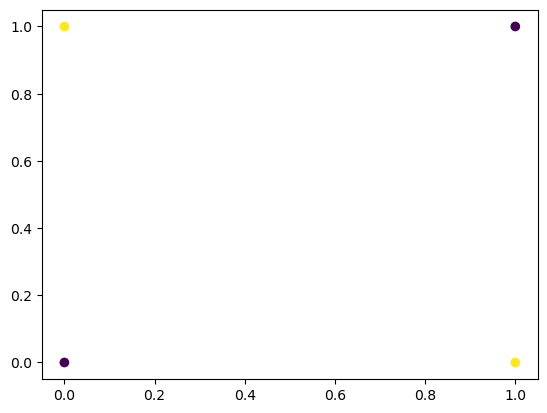

In [23]:
# Define XOR inputs -- prepend a constant of 1 for bias multiplication
samples = np.array([[0, 0],
                    [0, 1],
                    [1, 0],
                    [1, 1]])
targets = np.array([0, 1, 1, 0])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(samples[:, 0], samples[:, 1], c=targets)

In [24]:
import numpy as np
import pandas as pd
import time
model = Sequential(samples, targets)


# pg.build_model(loss=CrossentropyLoss, lr=0.01)
model.fit(samples, targets)

loss in sequential -3.908966897431388
[0 1 1 0] [0 1 1 0]
predicted y and true y [[0.27169345]
 [0.51314367]
 [0.27960286]
 [0.51463284]] [0 1 1 0]


# model saving and loading

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("XOR_solved.w")
print("Saved Model To disk")

In [ ]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model.load_weights("XOR_solved.w")
print("loaded model from disk")

# Handwritten digits MNIST

loading handwritten digits dataset

In [25]:
samples, targets = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

splitting about 60000 in train and 10000 in test

In [26]:
(X_train, X_test, y_train, y_test) = train_test_split(samples, targets, test_size = 0.15)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(59500, 784) (59500,) (10500, 784) (10500,)


normalizng the pixel values

In [28]:
samples = samples / 255.
num_features = samples.shape[1]
num_classes = 10
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

Layer Class

In [43]:
class Layer:
    def forward(self, inputs):
        pass
    
    def backward(self, inputs):
        pass
    
class Linear(Layer):
    def __init__(self, n_inputs, n_neurons):
        self.w = np.random.randn( n_inputs, n_neurons) - 0.5
        #self.b = np.random.randn(1 , n_neurons) - 0.5
        #print("bias in linear", self.b)
        
    def forward(self, inputs):
        print("in linear fw", inputs)
        self.inputs = inputs
        self.output = np.dot(self.inputs, self.w) 
#         print("forward", inputs.shape, self.w.shape, self.b.shape)
#         self.output = self.w @ np.concatenate((np.ones((self.inputs.shape[0], 1)), self.inputs), axis=1).T   
#         print("in linear output", self.output.shape)
        return self.output
    
    def backward(self, output_grad, lr = 0.1):
        print("in linear bw")
        w_grad = np.dot( output_grad.T, self.inputs)   #3  4
        print("w shape", self.w.shape)
        print("w_grad", w_grad.shape)
        #input_grad = np.dot(self.weights.T, output_grad)
        print(self.w.shape, w_grad.shape)
        self.w -= lr*(w_grad.T)
        #print("b shape", self.b.shape, "op_shape", output_grad.shape)
        #self.b -= lr*(output_grad)
#         if output_grad.ndim == 1:
#             output_grad = np.expand_dims(output_grad,axis = 0).T
        return np.dot(self.w,  output_grad.T )
    
class Sigmoid(Layer):
    def forward(self, inputs):
        self.inputs = inputs
        print("in sigmoid fw")
        self.output = 1 / ( 1+ np.exp(-self.inputs))
        return self.output
    
    def backward(self, output_grad):
        print("in sigmoid bw")
        print("sigmoid bw dloss", output_grad.shape)
        return self.inputs * ( 1-self.inputs) * output_grad.T
        
class HyperbolicTangent(Layer):
    
    def forward(self, inputs):
        self.output = np.tanh(inputs)
        print("in HT FW",inputs.shape, self.output.shape)
        return self.output
    
    def backward(self, output):
        return 1 - np.tanh(output)**2

class Softmax(Layer):
    def forward(self, inputs):
        exp_val = np.exp(inputs - np.max(inputs, axis = 1, keepdims= True))
        prob =  exp_val/ np.sum(exp_val, axis = 1, keepdims = True)
        self.output = prob
        return self.output
        
    def backward(self, output_grad):
        self.dw = self.output * (1-self.output) * output_grad.T
        return self.dw
    
class MultiCrossEntropy(Layer):                                 #multilcass
    def forward(self,inputs,  output):
        print(output)
        print(inputs)
        self.inputs = inputs
        print("multi", output.shape, inputs.shape)
        loss = -output * np.log(inputs.T)
        return np.sum(np.mean(loss, axis = 0))
        
    def backward(self, output):
        print("in cross bw")
        return output.T - self.inputs
        

Our Model

In [44]:
class Sequential(Layer):
    def __init__(self, X, y, layers):
        self.X = X
        self.y = y
        self.Losses =[]
        self.layers = layers
    def forward(self, x):
        for i in range(len(self.layers)):
            print("fw", self.layers[i])
            x = self.layers[i].forward(x)
        return x
    def backward(self, y):
        for j in reversed(range(len(self.layers))):
            print("bw", self.layers[j])
#             z = 0
#             z = c.forward(self.layers[j].forward(x.T, get_one_hot(y.astype(int), 3)))
#             print("Loss", z)
#             Losses.append(z)
#             d_loss = c.backward(x.T, get_one_hot(y.astype(int), 10))
            y = self.layers[j].backward(y)  
        return y
    def fit(self, samples, target):
        batch_size = 32
        correct = 0
        lr = 0.001
        for batch_idx in range(0, samples.shape[1], batch_size):
            start_idx = batch_idx
            end_idx = start_idx + batch_size if start_idx + batch_size < samples.shape[0] else samples.shape[0]
            batch_samples = samples[start_idx : end_idx]
            batch_targets = get_one_hot(targets[start_idx : end_idx].astype(int), 10)
            print("batch samples", batch_samples.shape)
            print("batch targets", batch_targets)
            y_hat = self.forward(batch_samples)
            c = MultiCrossEntropy()
            loss = c.forward(y_hat.T, batch_targets)
            self.Losses.append(loss)
            print("loss in sequential", loss)
            d_loss = c.backward(batch_targets)
            print("dloss to be passed in bw", d_loss)
            y = self.backward(d_loss)         
#             correct += np.sum(np.argmax(layer1_z, axis=0) == targets[start_idx : end_idx].astype(int)   
    def predict(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i].forward(x)
            print("output in predict", x[0:5])
        return x

Using HyperBolic Tangent

In [32]:
layers = [Linear(28*28, 100), HyperbolicTangent(), Linear(100, 10), HyperbolicTangent()]
# layers = [Linear(28*28, 100), Sigmoid(), Linear(100, 10), Sigmoid()]
pg = Sequential(X_train, y_train, layers)
pg.fit(X_train, y_train)

batch samples (32, 784)
batch targets [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 

ValueError: shapes (32,10) and (32,100) not aligned: 10 (dim 1) != 32 (dim 0)

In [33]:

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
y_pred = pg.predict(X_test[0:3])
y_pred1 = np.argmax(y_pred)
print("x_ttest",y_test[0:5])
print("y_pred", y_pred[0:5])
#print("y_pred1", y_pred1)

(59500, 784) (59500,) (10500, 784) (10500,)
in linear fw [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
output in predict [[-21172.71994333 -25624.85889887 -21716.44157042 -19015.56169815
  -18324.8043899  -22962.85551819 -21191.07866086 -27340.74674174
  -15242.44458262 -24916.42687401 -22886.66173919 -22959.8026722
  -22130.78116244 -23516.34643988 -23672.39451366 -23342.39922708
  -20714.46663444 -21547.76442066 -12201.11844065 -22042.12824867
  -22145.94704021 -19755.93456873 -25494.73893022 -20645.83635999
  -22535.24843065 -23515.95470025 -14641.59368299 -20116.77604135
  -21645.51012034 -18998.04717642 -20128.85453142 -18689.5593099
  -24954.41123014 -12025.10548939 -19594.03133056 -16323.62595112
  -15812.63903183 -17267.49199802 -13247.26796983 -18687.24131684
  -19915.02213231 -22807.2535641  -20884.02977234 -25461.45504373
  -20106.57933676 -25392.46100547 -20403.46012333 -26689.04133283
  -20356.40285351 -19378.87298942 -22852.92331989 -20219.34

using Sigmoid

In [34]:
layers = [Linear(28*28, 100), Sigmoid(), Linear(100, 10), Sigmoid()]
pg = Sequential(X_train, y_train, layers)
pg.fit(X_train, y_train)

batch samples (32, 784)
batch targets [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 

C:\Users\computer\AppData\Local\Temp\ipykernel_12036\3001588322.py:41: RuntimeWarning: overflow encountered in exp
  self.output = 1 / ( 1+ np.exp(-self.inputs))


batch samples (32, 784)
batch targets [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 

fw <__main__.Linear object at 0x000002A006B24CA0>
in linear fw [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
fw <__main__.Sigmoid object at 0x000002A008B15150>
in sigmoid fw
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 

In [35]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
y_pred = pg.predict(X_test[0:3])
y_pred1 = np.argmax(y_pred)
print("x_ttest",y_test[0:5])
print("y_pred", y_pred[0:5])
#print("y_pred1", y_pred1)

(59500, 784) (59500,) (10500, 784) (10500,)
in linear fw [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
output in predict [[-1.35412727e+82 -1.77721641e+77 -1.70621397e+79  2.79726845e+81
   6.01330043e+75 -6.09038082e+77  7.71073101e+78 -4.27083105e+82
  -4.04890307e+84  1.44236881e+80 -5.43328403e+79 -2.97446027e+83
  -2.11582425e+76 -2.01057672e+81 -7.03610804e+80  5.18474796e+79
  -5.11653128e+83 -1.44571411e+86  1.54722415e+78 -4.18387288e+82
  -2.70096155e+86 -2.74663909e+83 -3.41187547e+73 -1.01026512e+76
  -3.31109031e+80 -7.10702616e+82 -2.41554586e+77 -1.96134939e+77
  -5.02832458e+84 -4.47362967e+80 -1.38013771e+83  2.48040062e+76
  -8.92868480e+80  5.43139683e+79 -2.11268965e+78 -2.12087617e+80
  -6.60899262e+84  8.38786673e+80  2.66654226e+79  8.93306959e+78
  -1.58291990e+81 -6.30946504e+82 -4.16653704e+79 -1.69723956e+79
   9.67396183e+80 -1.74887658e+81 -1.36713499e+80 -8.46566541e+77
  -7.18887993e+83 -1.18409796e+82 -5.51857474e+83 -9.5639

C:\Users\computer\AppData\Local\Temp\ipykernel_12036\3001588322.py:41: RuntimeWarning: overflow encountered in exp
  self.output = 1 / ( 1+ np.exp(-self.inputs))


using Softmax

In [45]:
layers = [Linear(28*28, 100), Softmax(), Linear(100, 10), Softmax()]
pg = Sequential(X_train, y_train, layers)
pg.fit(X_train, y_train)

batch samples (32, 784)
batch targets [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 

w shape (100, 10)
w_grad (10, 100)
(100, 10) (10, 100)
bw <__main__.Softmax object at 0x000002A008C64070>
bw <__main__.Linear object at 0x000002A008C640D0>
in linear bw
w shape (784, 100)
w_grad (100, 784)
(784, 100) (100, 784)
batch samples (32, 784)
batch targets [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0.

In [46]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
y_pred = pg.predict(X_test[0:3])
y_pred1 = np.argmax(y_pred)
print("x_ttest",y_test[0:5])
print("y_pred", y_pred[0:5])
#print("y_pred1", y_pred1)

(59500, 784) (59500,) (10500, 784) (10500,)
in linear fw [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
output in predict [[-22225.40681112 -22194.87276064 -12701.6339876  -20022.66188625
  -22347.12671846 -22287.94345704 -19661.47083501 -23399.95506987
  -27839.46098159 -17423.01748788 -21481.12929563 -22226.43343961
  -18117.36511419 -28543.67544422 -20117.39688207 -18234.24583824
  -20704.05677598 -20666.39293021 -20811.54666329 -25479.45254092
  -25716.22689772  -2767.9217483  -19822.11295095 -16503.70402355
  -18271.64969924 -20701.15725103 -16865.87207064 -22751.11807716
  -20467.78307033 -19209.94869958 -23652.79349489 -23937.37036845
  -19755.30221559 -22579.99194993 -23105.61111834 -20065.695862
  -19717.58237581 -23088.68374724 -23713.99214178 -24797.86438586
  -26305.56850596 -18880.62891443 -17771.43895506 -25359.7326814
  -21502.7153174  -20848.16186888 -24752.04169821 -17067.54615314
  -20855.33453753 -17506.27211678 -18853.87246349  -7872.494